In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as ss
import matplotlib.pyplot as plt
import plotly.express as px
sns.set(rc={'figure.figsize':(8, 4)}, style="whitegrid")

In [2]:
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from sklearn.cluster import AgglomerativeClustering

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


**Приложение доставки**  

В приложение по доставке продуктов внедрена умная система рекомендаций товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.  

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1: пользователи с новой системой рекомендаций, в группе 0: пользователи со старой версией приложения, где нет рекомендации товаров.  

Необходимо оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.  

Дать аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.  

В данных - логи заказов пользователей:  

- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи  
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ  
- ab_products – подробная информация о продуктах, их название и стоимость  

In [3]:
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-gazizova/MathStat/ab_users_data.csv'
users = pd.read_csv(path, parse_dates=['time', 'date'])  
users.head(7)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0
6,969,1262,create_order,2022-08-26 00:06:25,2022-08-26,0


In [4]:
users.shape

(4337, 6)

In [5]:
users.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [6]:
users.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [7]:
# количество пользователей группы  1

users.query("group == 1").user_id.nunique()

502

In [8]:
# количество пользователей группы  0

users.query("group == 0").user_id.nunique()

515

In [9]:
# какие действия совершают

users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

В этой таблице представлена история заказов пользователей, а также есть информация о том, какие заказы создавали и отменяли пользователи.  
Посмотрим, сколько созданных и отмененных заказов в двух группах. Количество пользователей в группах примерно одинаковое - чуть более 500 пользователей. 

In [10]:
# сколько созданных и отмененных заказов в двух группах

df = users.groupby(['group', 'action']) \
          .agg({'action':'count'}).rename(columns={'action':'sum'})
df

sum
group action            
0     cancel_order    82
      create_order  1609
1     cancel_order   132
      create_order  2514

In [11]:
# посмотрим размер групп
users.groupby("group", as_index=False).size()

,group,size
0,0,1691
1,1,2646


In [12]:
# смотрим процентное соотношение созданных и отмененных заказов в группе 1

df1 = users.query("group == 1")
df1.action.value_counts(normalize=True).mul(100)

create_order    95.011338
cancel_order     4.988662
Name: action, dtype: float64

In [13]:
# смотрим процентное соотношение созданных и отмененных заказов в группе 0 

df0 = users.query("group == 0")
df0.action.value_counts(normalize=True).mul(100)

create_order    95.150798
cancel_order     4.849202
Name: action, dtype: float64

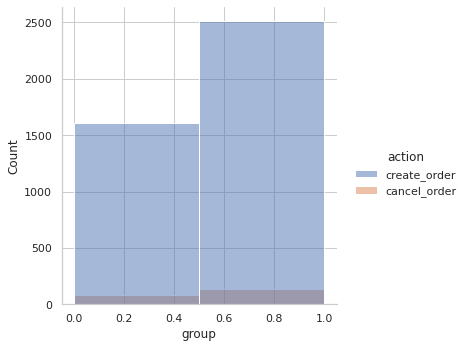

In [14]:
# построим диаграмму и посмотрим визуально на различия
    
sns.displot(data=users[['group', 'action']].dropna(), x="group", hue="action", bins=2)

В группе 1 мы видим существенную разницу в количестве созданных заказов, при этом, можно наблюдать, что процент отмен в обоих случаях одинаковый и равен примерно 5%.  

Можно рассмотреть следующие метрики:
- количество и сумма заказов по группам,  
- средняя сумма покупки (стоимость одного заказа пользователя),
- общая стоимость всех заказов по группам.


In [15]:
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-gazizova/MathStat/ab_orders.csv'
orders = pd.read_csv(path, parse_dates=['creation_time'])  
orders.head(7)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"
5,1261,2022-08-26 00:05:35,"{30, 35, 69, 6}"
6,1262,2022-08-26 00:06:25,"{23, 69, 45, 33}"


In [16]:
orders.shape

(4123, 3)

In [17]:
orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [18]:
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [19]:
# преобразуем значения в столбце product_ids в список, чтобы было удобней работать с данными

orders.product_ids = orders.product_ids.apply(lambda x: x.replace('{','').replace('}','').split(', '))

In [20]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [21]:
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-gazizova/MathStat/ab_products.csv'
products = pd.read_csv(path)  
products.head(7)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
5,6,сухарики,25.0
6,7,кофе зерновой,350.8


In [22]:
products.shape

(87, 3)

In [23]:
products.nunique()

product_id    87
name          87
price         63
dtype: int64

In [24]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [25]:
# установим в качестве индекса product_id

products = products.set_index('product_id')
products

,name,price
product_id,,
1,сахар,150.0
2,чай зеленый в пакетиках,50.0
3,вода негазированная,80.4
4,леденцы,45.5
5,кофе 3 в 1,15.0
...,...,...
83,вафли,55.0
84,мандарины,90.4
85,варенье,200.3


In [26]:
# объединим таблицы orders и users в одну

users_and_orders = users.merge(orders, on='order_id')
users_and_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]"


In [27]:
# добавим два новых столбца со списком продуктов в корзине и общей суммой покупки

users_and_orders["product_names"] = users_and_orders["product_ids"].apply(lambda x: ", ".join(products.loc[[int(c) for c in x], 'name']))

users_and_orders["total_price"] = users_and_orders["product_ids"].apply(lambda x: products.loc[[int(c) for c in x], 'price'].sum())

users_and_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_names,total_price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]","сок ананасовый, сок мультифрукт, мука, мандарины",408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]","сосиски, чай черный в пакетиках, бублики",250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]","чай черный в пакетиках, макароны, вода газиров...",310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]","молоко, сухарики",85.0
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]","молоко, сухарики",85.0


In [28]:
# посмотрим, как распределены количество заказов и общие суммы заказов по пользователям

user_sum_ord = users_and_orders.groupby(['user_id','group'], as_index=False)  \
                         .agg({'order_id':'nunique', 'total_price':'sum'})  \
                         .rename(columns={'order_id':'amount', 'total_price':'summa'})
user_sum_ord.head()

,user_id,group,amount,summa
0,964,0,2,718.9
1,965,1,9,4155.5
2,966,0,1,170.0
3,967,1,5,1137.4
4,968,0,3,1590.7


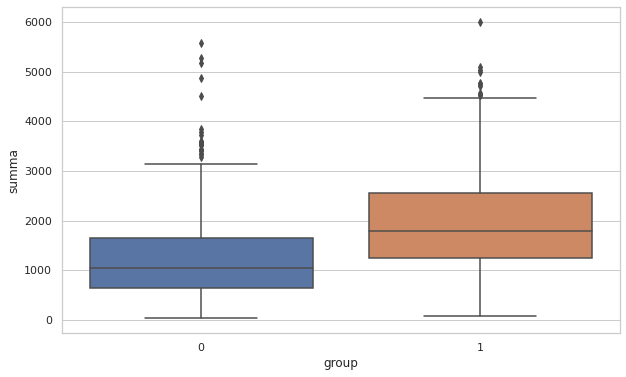

In [29]:
# построим диаграмму боксплот, разделив значения по группам

sns.set(style='whitegrid', rc={'figure.figsize' : (10,6)})
sns.boxplot(y='summa', x='group', data = user_sum_ord)

На данной диаграмме видно, что в первой группе пользователей суммарная стоимость заказа каждого пользователя выше, чем в группе 0, медианное значение также расположено выше. Кроме того, размах значений группы 1 существенно больше группы 0.  

**Проверим нормальность распределения по количеству и суммам заказов групп с помощью теста Шапиро-Уилка**

In [30]:
# Группа 0

shapiro_a0 = ss.shapiro(user_sum_ord.query('group==0').amount)
print(f'тест Шапиро-Уилка для количества товаров в заказе группы 0: \n {shapiro_a0} \n')

shapiro_s0 = ss.shapiro(user_sum_ord.query('group==0').summa)
print(f'тест Шапиро-Уилка для стоимости заказа группы 0: \n {shapiro_s0}')

тест Шапиро-Уилка для количества товаров в заказе группы 0: 
 ShapiroResult(statistic=0.8348702788352966, pvalue=1.0818117861129074e-22) 

тест Шапиро-Уилка для стоимости заказа группы 0: 
 ShapiroResult(statistic=0.8934255838394165, pvalue=1.9825922824313846e-18)


In [31]:
# Группа 1

shapiro_a1 = ss.shapiro(user_sum_ord.query('group==1').amount)
print(f'тест Шапиро-Уилка для количества товаров в заказе группы 1: \n {shapiro_a1} \n')

shapiro_s1 = ss.shapiro(user_sum_ord.query('group==1').summa)
print(f'тест Шапиро-Уилка для стоимости заказа группы 1: \n {shapiro_s1}')

тест Шапиро-Уилка для количества товаров в заказе группы 1: 
 ShapiroResult(statistic=0.9596871137619019, pvalue=1.7252431427916548e-10) 

тест Шапиро-Уилка для стоимости заказа группы 1: 
 ShapiroResult(statistic=0.9725738167762756, pvalue=4.3736186228215956e-08)


In [32]:
#через pingouin

pg.normality(data=user_sum_ord, dv="amount", group="group", method="normaltest")

pg.normality(data=user_sum_ord, dv="summa", group="group", method="normaltest")

,W,pval,normal
0,152.128172,9.242453e-34,False
1,32.126612,1.056318e-07,False


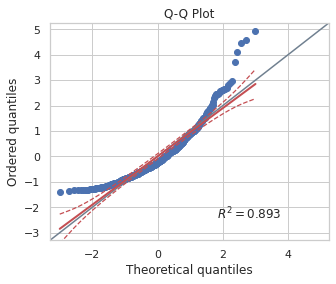

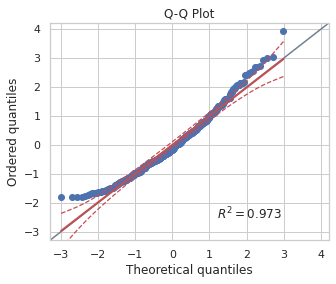

In [33]:
# построим qq-plot графики

pg.qqplot(user_sum_ord.query('group==0').summa)
pg.qqplot(user_sum_ord.query('group==1').summa)

**Вывод:**
На основе проведенных тестов Шапиро-Уилка, а также через метод qq-plot модуля pingouin мы можем заключить, что распределение наблюдений обеих метрик внутри групп (количества и суммы заказа по пользователю) **не является нормальным**, так как во всех случаях p-value имеет очень небольшое значение и существенно меньше 0,05. На графиках qq-plot наблюдается существенное отклонение  

**Проверяем гомогенность дисперсий внутри групп с помощью метода Левена**

In [34]:
#через scipy

ss.levene(user_sum_ord.query('group==0').summa, user_sum_ord.query('group==1').summa)
#ss.levene(user_sum_ord.query('group==0').amount, user_sum_ord.query('group==1').amount)

LeveneResult(statistic=18.39458896191686, pvalue=1.9670519137719107e-05)

In [35]:
#через pingouin

pg.homoscedasticity(data=user_sum_ord, dv="amount", group="group")

,W,pval,equal_var
levene,16.16773,0.000062,False


В результате проведенного теста Левена - делаем вывод о том, что дисперсии не гомогенны.

**Теперь проверим наши метрики с помощью методов дисперсионного анализа ANOVA**

In [36]:
# ANOVA

ss.f_oneway(user_sum_ord.query('group==0').summa, user_sum_ord.query('group==1').summa)

F_onewayResult(statistic=136.55780558448708, pvalue=1.0901045699349648e-29)

In [37]:
# через pingouin

pg.anova(data=user_sum_ord, dv="summa", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,1,1015,136.557806,1.090105e-29,0.118585


In [38]:
# тест Уэлча в pingouin

pg.welch_anova(data=user_sum_ord, dv="summa", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,1,981.806998,136.004647,1.589864e-29,0.118585


**Вывод:**  
Проведя дисперсионный анализ методом ANOVA, а также тест Уэлча, мы также отклоняем гипотезу Н0, и делаем вывод, что дисперсии двух групп не гомогенны и имеют существенные статистические различия. 

Соответственно, далее рассмотрим и сравним средние суммы заказов по пользователям. 

In [39]:
# посмотрим, как распределены количество заказов и средние суммы заказов по пользователям

user_avg_ord = users_and_orders.groupby(['user_id', 'group'], as_index=False)  \
                         .agg({'order_id':'nunique', 'total_price':'mean'})  \
                         .rename(columns={'order_id':'amount', 'total_price':'avg'})
user_avg_ord.head()

,user_id,group,amount,avg
0,964,0,2,359.450000
1,965,1,9,461.722222
2,966,0,1,85.000000
3,967,1,5,227.480000
4,968,0,3,530.233333


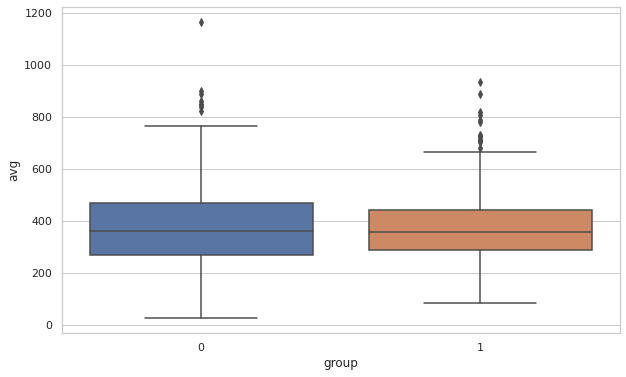

In [40]:
# построим диаграмму боксплот средней стоимости заказов пользователей

sns.set(style='whitegrid', rc={'figure.figsize' : (10,6)})
sns.boxplot(y='avg', x='group', data = user_avg_ord)

На данной диаграмме видим, что средняя стоимость заказов в пределах группы 0 и группы 1 не сильно отличается, медианное значение обеих групп распологаются примерно на одном уровне. Однако размах средних значений группы 1 уже, чем размах средних значений группы 0.

In [41]:
# проверяем нормальность распределения через pingouin

pg.normality(data=user_avg_ord, dv="avg", group="group", method="normaltest")

,W,pval,normal
0,53.288835,2.682110e-12,False
1,67.695100,1.996162e-15,False


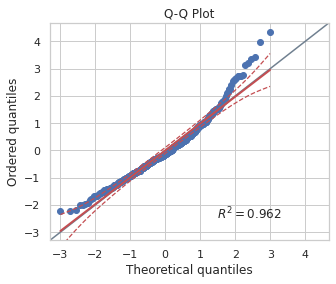

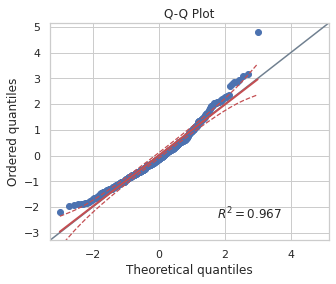

In [42]:
pg.qqplot(user_avg_ord.query('group==1').avg)
pg.qqplot(user_avg_ord.query('group==0').avg)

In [43]:
# сравним средние однофакторным дисперсионным анализом

ss.f_oneway(user_avg_ord.query('group==1').avg, user_avg_ord.query('group==0').avg)

F_onewayResult(statistic=0.9221231014791772, pvalue=0.3371468230263419)

In [44]:
# метод Тьюки через pingouin

pg.pairwise_tukey(data=user_avg_ord, dv="avg", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,1,382.174954,373.282613,8.892341,9.260227,0.960272,0.337145,0.060184


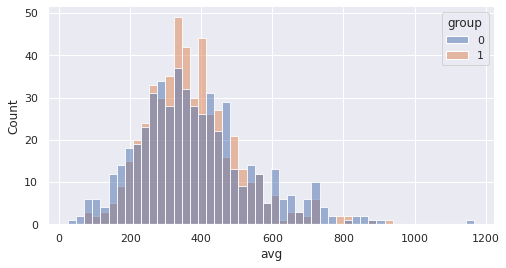

In [45]:
# построим диаграмму распределения средних значений двух групп

sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(user_avg_ord, x='avg', bins=50, hue='group')
sns.despine()

В ходе проведенного однофакторного анализа, получили Значение статистики равным 0.922, а р-уровень значимости составил 0.337. Практически такие же результаты получены методом Тьюки. Это дает нам право принять нулевую гипотезу о равенстве средних.

In [46]:
# посмотрим, как распределены общие суммы созданных и отмененных заказов по группам

groups = users_and_orders.groupby(['group', 'action'])  \
                         .agg({'action':'count', 'total_price':'sum'})  \
                         .rename(columns={'action':'count', 'total_price':'summa'}) \
                         .reset_index() 

groups                                                #.query("action == 'create_order'")

,group,action,count,summa
0,0,cancel_order,82,30032.9
1,0,create_order,1609,613488.8
2,1,cancel_order,132,50603.6
3,1,create_order,2514,929232.0


In [47]:
# Процентная доля отмененных заказо в группе 1

g1 = groups.query("group == 1 and action == 'cancel_order'").summa / groups.query("group == 1").summa.sum()*100
g1

2    5.164499
Name: summa, dtype: float64

In [48]:
# Процентная доля отмененных заказо в группе 0

g0 = groups.query("group == 0 and action == 'cancel_order'").summa / groups.query("group == 0").summa.sum()*100
g0

0    4.66696
Name: summa, dtype: float64

In [49]:
# Суммарная стоимость всех заказов группы 0

g0_itog_sum = groups.loc[groups['group'] == 0, 'summa'].iloc[1] - groups.loc[groups['group'] == 0, 'summa'].iloc[0]
g0_itog_sum.round(2) 

583455.9

In [50]:
# Суммарная стоимость всех заказов группы 1

g1_itog_sum = groups.loc[groups['group'] == 1, 'summa'].iloc[1] - groups.loc[groups['group'] == 1, 'summa'].iloc[0]
g1_itog_sum.round(2)

878628.4

Суммарная стоимость всех заказов группы 1 (878628.4) также существенно отличается от суммарной стоимости группы 0 (583455.9), но это логично, так как в первой группе самих заказов также больше.

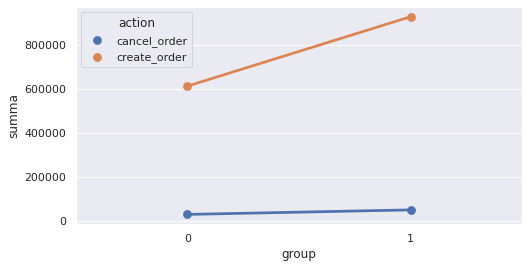

In [51]:
# визуализируем полученные результаты - построим график взаимодействия 

sns.pointplot(x="group", y="summa", hue="action", data=groups, capsize=0.2)

**Вывод**   
По графику мы видим взаимодействие факторов между группами: увеличилась общая сумма всех заказов в группе 1 по сравнению с группой 0, при этом сумма отмененных заказов изменилась не сильно, что в целом хорошо. Поэтому принимаем решение - **включить новую  систему рекомендаций на всех пользователей.**

Внести правки:
- отменённые заказы тоже имеют статус созданных, поэтому простой фильтрации по статусу создания недостаточно; 
- посмотреть на количество заказов, так как выручка выросла именно из-за них.